# Unbinned Profiled Unfolding

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Generate simulation and data events from Gaussian distribution

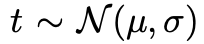

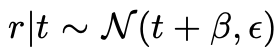

In [2]:
Ndata = 1000
Nsim = 1000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

In [3]:
bins = np.linspace(-3,3,10)

Define w0 (parameters: sigma, mu (correspond to simulation), a, b (correspond to data)), 

and w1 (parameters: epsilon, beta (correspond to simulation), c, d (correspond to data))
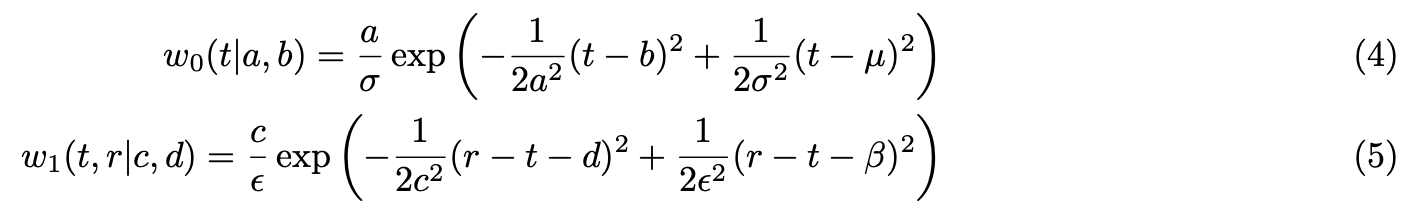

In [4]:
def gauss_ratio(x,sigma,mu,a,b):
    return (a/sigma)*np.exp(-0.5*(x-b)**2/a**2+0.5*(x-mu)**2/sigma**2)

def w0(t,sigma,mu,a,b):
    return gauss_ratio(t,sigma,mu,a,b)

def w1(r,t,epsilon,beta,c,d):
    return gauss_ratio(r,epsilon,t+beta,c,t+d)

def log_gauss(x,sigma,mu):
    return -0.5*(x-mu)**2/sigma**2

Scan through b and c and fix all the other parameters

Calculate likelihood scan

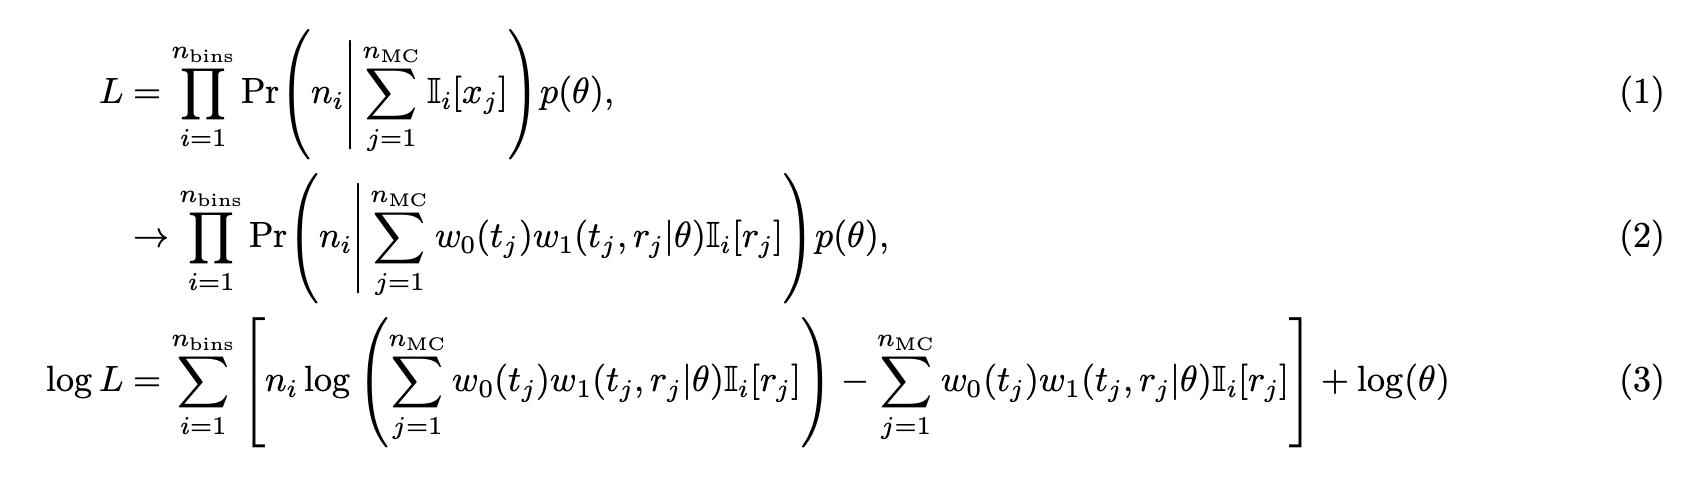

In [5]:
lls = []
for test_mu in np.linspace(-0.5,0.5,50):
    #print(test_mu)
    lls += [[]]
    for test_epsilon in np.linspace(0.8,1.2,50):
        per_bin = 0
        for i in range(len(bins)):
            mysum = np.sum((np.digitize(R_sim,bins)==i)*w0(T_sim,sigma_sim,mu_sim,1,test_mu)*w1(R_sim,T_sim,epsilon_sim,beta_sim,test_epsilon,0))
            ni = np.sum((np.digitize(R_data,bins)==i))
            if (mysum > 0):
                per_bin+=ni*np.log(mysum) - mysum + log_gauss(test_epsilon,epsilon_sim*0.1,epsilon_sim)
            pass
        lls[-1] += [per_bin]

Text(0.5, 1.0, 'Log Likelihood')

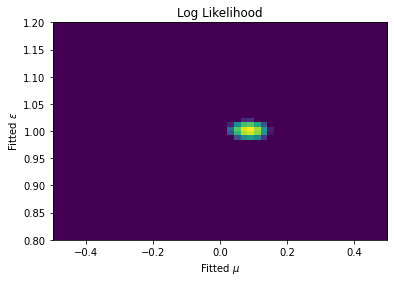

In [6]:
extent = -0.5, 0.5,0.8, 1.2
lls = np.array(lls)
plt.imshow(lls.T, extent=extent, aspect='auto', vmin = np.max(lls)-1, vmax = np.max(lls))
plt.xlabel("Fitted $\mu$")
plt.ylabel("Fitted $\epsilon$")
plt.title("Log Likelihood")

## Now try to solve the problem with deep learning!

In [7]:
import torch
import matplotlib.pyplot as plt

/afs/cern.ch/work/c/cchan/hmumuTorch/env/lib64/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
Ndata = 1000
Nsim = 100000

mu_sim = 0
sigma_sim = 1
beta_sim = 0
epsilon_sim = 1

mu_data = 0.2
sigma_data = 1
beta_data = 0
epsilon_data = 1

T_sim = np.random.normal(mu_sim,sigma_sim,Nsim)
R_sim = np.random.normal(T_sim+beta_sim,epsilon_sim)

epsilon_sim_theta_for_parametrization = np.random.uniform(0.5, 1.5, Nsim)
epsilon_sim_theta = np.random.uniform(0.5, 1.5, Nsim)
R_sim_theta = []
for i in range(Nsim):
    R_sim_theta.append(np.random.normal(T_sim[i]+beta_sim,epsilon_sim_theta[i])) # use the same T_sim for R_sim variation
R_sim_theta = np.array(R_sim_theta)

T_data = np.random.normal(mu_data,sigma_data,Ndata)
R_data = np.random.normal(T_data+beta_data,epsilon_data)

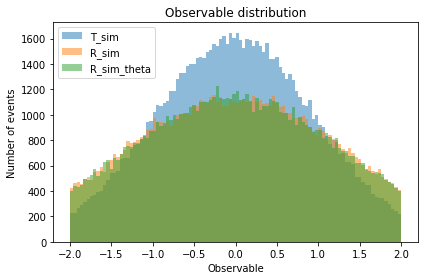

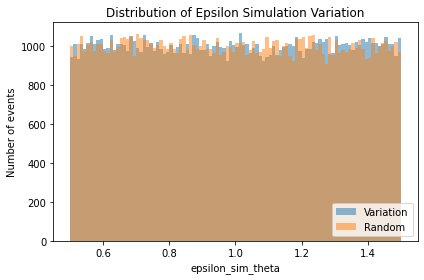

In [29]:
plt.hist(T_sim, range=(-2, 2), density=False, bins=100, label="T_sim", alpha=0.5)
plt.hist(R_sim, range=(-2, 2), density=False, bins=100, label="R_sim", alpha=0.5)
plt.hist(R_sim_theta, range=(-2, 2), density=False, bins=100, label="R_sim_theta", alpha=0.5)
plt.xlabel('Observable')
plt.ylabel('Number of events')
plt.title(r'Observable distribution')
plt.legend(loc='upper left')#, framealpha=0)
plt.tight_layout()
plt.show()
plt.clf()

plt.hist(epsilon_sim_theta, range=(0.5, 1.5), density=False, bins=100, label="Variation", alpha=0.5)
plt.hist(epsilon_sim_theta_for_parametrization, range=(0.5, 1.5), density=False, bins=100, label="Random", alpha=0.5)
plt.xlabel('epsilon_sim_theta')
plt.ylabel('Number of events')
plt.title(r'Distribution of Epsilon Simulation Variation')
plt.legend(loc='lower right')#, framealpha=0)
plt.tight_layout()
plt.show()

In [39]:
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader

class w1_dataset(Dataset):
    def __init__(self, T_sim, R_sim, R_sim_theta, epsilon_sim_theta_for_parametrization, epsilon_sim_theta):
        self.inds = np.random.randint(0,len(R_sim_theta),len(R_sim)) # it is possible that the same index will be picked. Consider make all selected indices unique?
        
    def __len__(self):
        return len(R_sim)*2

    def __getitem__(self, idx):
        label = idx % 2
        i = idx // 2
        if label == 0:
            data = torch.tensor([R_sim[i], epsilon_sim_theta_for_parametrization[i], T_sim[i], T_sim[self.inds[i]]]) # use the same T_sim for R_sim variation
        else:
            data = torch.tensor([R_sim_theta[self.inds[i]], epsilon_sim_theta_for_parametrization[i], T_sim[i], T_sim[self.inds[i]]])
        return data, label

In [53]:
w1_ds = w1_dataset(T_sim, R_sim, R_sim_theta, epsilon_sim_theta_for_parametrization, epsilon_sim_theta)
w1_dataloader = DataLoader(w1_ds, batch_size=64, shuffle=True, num_workers=12)

In [54]:
batch = next(iter(w1_dataloader))
print(batch)

[tensor([[ 1.0448,  0.5774, -0.0654,  1.1597],
        [-2.2273,  1.0426, -0.0986, -0.1816],
        [ 0.1774,  1.0468, -1.2705, -0.6097],
        [-1.3266,  1.2339, -0.3813,  1.1610],
        [ 1.6104,  0.7076, -0.2738,  0.0545],
        [ 1.0299,  1.3695, -0.8306,  0.7814],
        [ 0.6888,  1.1974, -0.9522,  1.0288],
        [-0.1168,  1.3816,  0.6965, -0.2308],
        [-0.8501,  1.0173, -1.4801, -0.4817],
        [ 2.1570,  0.8726,  0.0354,  1.4224],
        [-0.6308,  0.7189, -0.2644, -0.1820],
        [-0.5984,  0.9199,  0.0225,  0.7935],
        [-1.8475,  1.0321,  1.1966, -0.1710],
        [ 1.5007,  1.0814,  1.6210, -0.0665],
        [ 2.3613,  1.4566,  1.3706,  0.5387],
        [-2.1298,  1.3733,  1.4896, -1.9860],
        [ 2.0265,  1.4814,  0.8078, -1.6715],
        [-0.7273,  0.7646,  0.9629,  1.3512],
        [-0.6195,  1.4454, -1.0280,  0.2534],
        [ 0.4440,  1.0397, -0.8439,  1.2476],
        [-0.3066,  1.4709,  0.6375, -0.2663],
        [-0.3439,  1.3172,  0.577

In [55]:
from pytorch_lightning import LightningModule